In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

labels are in train/gt and images are in /train/images

In [3]:
path_lbl = '/home/jupyter/AerialImageDataset/train/labels'
path_img = '/home/jupyter/AerialImageDataset/train/images'
path_validate = '/home/jupyter/AerialImageDataset/train/validate'

In [4]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/home/jupyter/AerialImageDataset/train/images/tyrol-w15.tif'),
 PosixPath('/home/jupyter/AerialImageDataset/train/images/tyrol-w6.tif'),
 PosixPath('/home/jupyter/AerialImageDataset/train/images/austin7.tif')]

In [5]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/home/jupyter/AerialImageDataset/train/labels/vienna17_P.tif'),
 PosixPath('/home/jupyter/AerialImageDataset/train/labels/chicago29_P.tif'),
 PosixPath('/home/jupyter/AerialImageDataset/train/labels/vienna32_P.tif')]

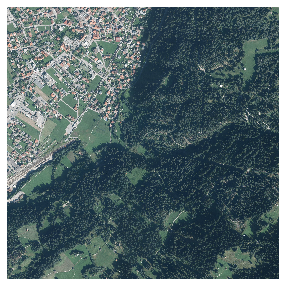

In [6]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [7]:
get_y_fn = lambda x: '{}/{}_P{}'.format(path_lbl, x.stem, x.suffix)

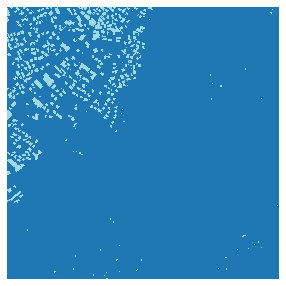

In [8]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5, ), alpha=1)

In [9]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([5000, 5000]), tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]))

In [10]:
size = src_size//16
bs = 8

In [11]:
labels = [0, 255]

The below custom classes are necessary to deal with the binary image segmentation datasets which use 0 and 255 to encode the mask

Links for reference:
https://github.com/fastai/fastai/issues/1540
https://forums.fast.ai/t/unet-binary-segmentation/29833/58

In [12]:
class SegLabelListCustom(SegmentationLabelList):
    def open(self, fn): return open_mask(fn, div=True)
    
class SegItemListCustom(SegmentationItemList):
    _label_cls = SegLabelListCustom
    
src = (SegItemListCustom.from_folder('/home/jupyter/AerialImageDataset/train/')
      .split_by_folder(train='images', valid='validate')
      .label_from_func(get_y_fn, classes=labels))

flip_vertical, max_lighting, max_zoom, max_warp as transformations along with default transformations provided by fastai.

In [13]:
data = (src.transform(get_transforms(max_rotate = 25, flip_vert=True), size=size, tfm_y=True)
       .databunch(bs=bs)
       .normalize(imagenet_stats))

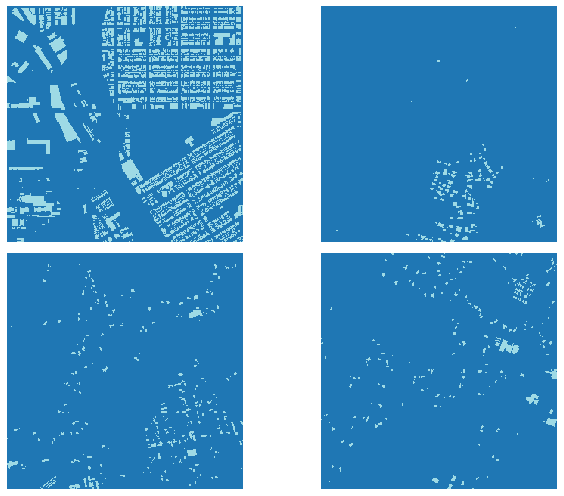

In [14]:
data.show_batch(2, figsize=(10,7), alpha=1)

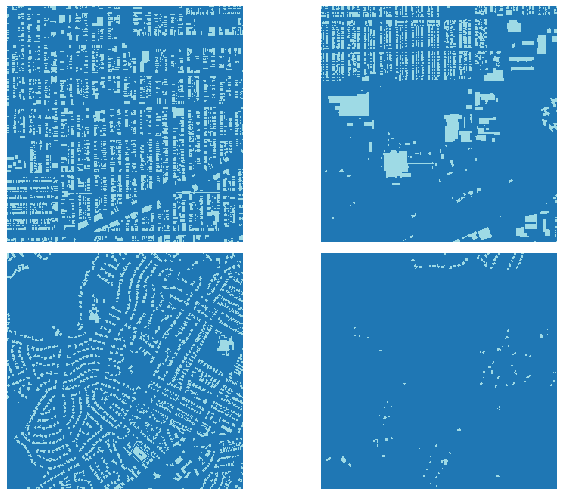

In [15]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid, alpha=1)

In [20]:
def custom_dice(input:Tensor, targs:Tensor, iou:bool=True)->Rank0Tensor:
    "Dice coefficient metric for binary target. If iou=True, returns iou metric, classic for segmentation problems."
    n = targs.shape[0]
    input = input.argmax(dim=1).view(n,-1)
    targs = targs.view(n,-1)
    intersect = (input*targs).sum().float()
    union = (input+targs).sum().float()
    if not iou: return 2. * intersect / union
    else: return intersect / (union-intersect+1.0)

In [21]:
metrics = custom_dice

In [22]:
wd=1e-2

In [23]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 8.32E-06
Min loss divided by 10: 1.58E-03


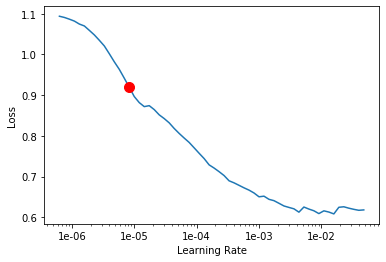

In [24]:
lr_find(learn)
learn.recorder.plot(suggestion=True)

In [27]:
learn.save('pre-train')

In [38]:
learn.load('pre-train');

In [39]:
learn.fit_one_cycle(10, 1e-05, callbacks=[callbacks.SaveModelCallback(learn, monitor='custom_dice', every='improvement', name='model-stage1')])

epoch,train_loss,valid_loss,custom_dice,time
0,0.964084,0.691552,0.092094,00:45
1,0.738786,0.471430,0.049421,00:45
2,0.618088,0.426678,0.077113,00:45
3,0.552478,0.400837,0.113866,00:45
4,0.509014,0.390013,0.142596,00:45
5,0.477115,0.374672,0.147881,00:45
6,0.453219,0.367615,0.151035,00:45
7,0.436593,0.366500,0.165653,00:45
8,0.423654,0.360546,0.151799,00:45
9,0.417196,0.360022,0.148210,00:45


Better model found at epoch 0 with custom_dice value: 0.09209360927343369.
Better model found at epoch 3 with custom_dice value: 0.11386576294898987.
Better model found at epoch 4 with custom_dice value: 0.1425963044166565.
Better model found at epoch 5 with custom_dice value: 0.14788122475147247.
Better model found at epoch 6 with custom_dice value: 0.15103460848331451.
Better model found at epoch 7 with custom_dice value: 0.16565315425395966.


In [49]:
learn.load('model-stage1');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.16E-08
Min loss divided by 10: 5.01E-05


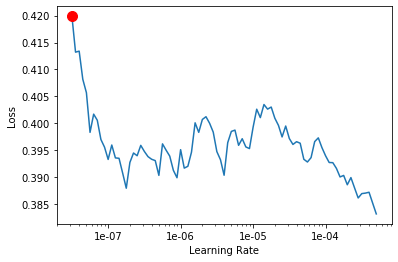

In [47]:
lr_find(learn, start_lr=1e-08, end_lr=1e-03)
learn.recorder.plot(suggestion=True)

In [50]:
learn.fit_one_cycle(10, 1e-05, callbacks=[callbacks.SaveModelCallback(learn, monitor='custom_dice', every='improvement', name='model-stage2')])

epoch,train_loss,valid_loss,custom_dice,time
0,0.393358,0.361532,0.152139,00:45
1,0.393661,0.357343,0.129675,00:45
2,0.394760,0.347632,0.144872,00:45
3,0.389218,0.347761,0.198757,00:45
4,0.385586,0.335717,0.167279,00:45
5,0.380410,0.330696,0.183359,00:45
6,0.379558,0.333306,0.205213,00:45
7,0.377056,0.327850,0.155049,00:45
8,0.372715,0.327971,0.152938,00:45
9,0.369521,0.327041,0.157374,00:45


Better model found at epoch 0 with custom_dice value: 0.15213918685913086.
Better model found at epoch 3 with custom_dice value: 0.19875670969486237.
Better model found at epoch 6 with custom_dice value: 0.2052125781774521.


In [52]:
learn.load('model-stage2');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.02E-07
Min loss divided by 10: 2.29E-05


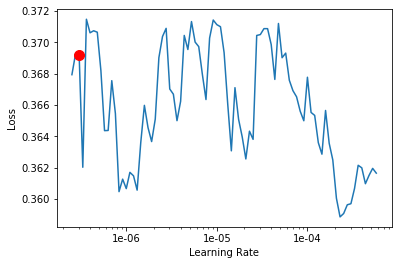

In [53]:
lr_find(learn, start_lr=1e-07, end_lr=1e-03)
learn.recorder.plot(suggestion=True)

In [54]:
learn.fit_one_cycle(10, 1e-04, callbacks=[callbacks.SaveModelCallback(learn, monitor='custom_dice', every='improvement', name='model-stage3')])

epoch,train_loss,valid_loss,custom_dice,time
0,0.392707,0.331306,0.119153,00:45
1,0.381708,0.312927,0.191635,00:45
2,0.370851,0.316866,0.108927,00:45
3,0.359325,0.291770,0.185123,00:45
4,0.347049,0.286072,0.251973,00:45
5,0.336913,0.279157,0.247382,00:45
6,0.329955,0.279186,0.208754,00:45
7,0.323735,0.277698,0.225905,00:45
8,0.317947,0.275003,0.279820,00:45
9,0.314465,0.274222,0.265463,00:45


Better model found at epoch 0 with custom_dice value: 0.11915311962366104.
Better model found at epoch 1 with custom_dice value: 0.19163456559181213.
Better model found at epoch 4 with custom_dice value: 0.2519729733467102.
Better model found at epoch 8 with custom_dice value: 0.27982044219970703.


In [56]:
learn.load('model-stage3');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.25E-06
Min loss divided by 10: 1.20E-05


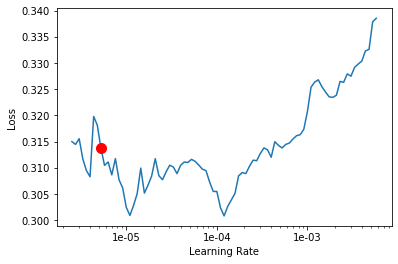

In [57]:
lr_find(learn, start_lr=1e-06, end_lr=1e-02)
learn.recorder.plot(suggestion=True)

In [58]:
learn.fit_one_cycle(10, 8e-05, callbacks=[callbacks.SaveModelCallback(learn, monitor='custom_dice', every='improvement', name='model-stage4')])

epoch,train_loss,valid_loss,custom_dice,time
0,0.312618,0.273726,0.264691,00:45
1,0.313696,0.280104,0.308466,00:45
2,0.315745,0.279703,0.321145,00:45
3,0.318249,0.374106,0.344269,00:45
4,0.326973,0.275340,0.249980,00:45
5,0.323149,0.269752,0.247731,00:45
6,0.321828,0.270371,0.206266,00:45
7,0.316333,0.266269,0.233776,00:45
8,0.311444,0.264602,0.281036,00:45
9,0.307917,0.264257,0.275990,00:45


Better model found at epoch 0 with custom_dice value: 0.26469096541404724.
Better model found at epoch 1 with custom_dice value: 0.30846571922302246.
Better model found at epoch 2 with custom_dice value: 0.3211447596549988.
Better model found at epoch 3 with custom_dice value: 0.34426888823509216.


In [66]:
learn.load('model-stage4');

In [67]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.58E-05
Min loss divided by 10: 5.01E-05


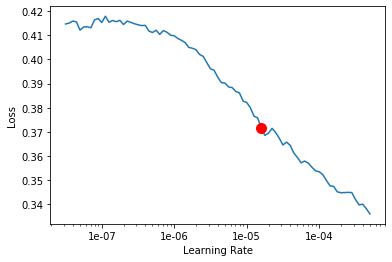

In [68]:
lr_find(learn, start_lr=1e-08, end_lr=1e-03)
learn.recorder.plot(suggestion=True)

In [70]:
learn.fit_one_cycle(50, max_lr=slice(1e-06, 1e-04), callbacks=[callbacks.SaveModelCallback(learn, monitor='custom_dice', every='improvement', name='model-stage5')])

epoch,train_loss,valid_loss,custom_dice,time
0,0.286702,0.257397,0.288353,00:45
1,0.288774,0.256648,0.296680,00:45
2,0.289013,0.256428,0.282290,00:45
3,0.288152,0.255585,0.316162,00:46
4,0.292224,0.269838,0.365282,00:45
5,0.291531,0.257480,0.334609,00:45
6,0.289796,0.256427,0.248344,00:45
7,0.287106,0.268085,0.211859,00:46
8,0.286536,0.257584,0.359768,00:46
9,0.289701,0.255645,0.316926,00:46


Better model found at epoch 0 with custom_dice value: 0.28835329413414.
Better model found at epoch 1 with custom_dice value: 0.29667961597442627.
Better model found at epoch 3 with custom_dice value: 0.3161619305610657.
Better model found at epoch 4 with custom_dice value: 0.36528244614601135.
Better model found at epoch 11 with custom_dice value: 0.3773954510688782.
Better model found at epoch 18 with custom_dice value: 0.3917832672595978.
Better model found at epoch 22 with custom_dice value: 0.4002901315689087.
Better model found at epoch 25 with custom_dice value: 0.4116379916667938.


In [72]:
learn.load('model-stage5');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.98E-08
Min loss divided by 10: 4.47E-06


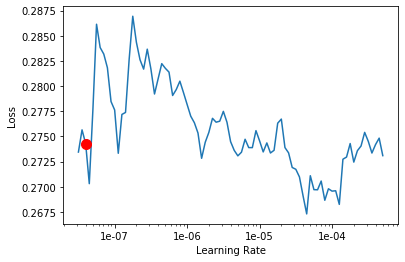

In [73]:
lr_find(learn, start_lr=1e-08, end_lr=1e-03)
learn.recorder.plot(suggestion=True)

In [74]:
learn.fit_one_cycle(50, max_lr=slice(1e-05, 1e-04), callbacks=[callbacks.SaveModelCallback(learn, monitor='custom_dice', every='improvement', name='model-stage6')])

epoch,train_loss,valid_loss,custom_dice,time
0,0.273367,0.238398,0.383598,00:45
1,0.267842,0.239018,0.306256,00:45
2,0.264474,0.236188,0.359480,00:45
3,0.261468,0.235432,0.352520,00:45
4,0.259959,0.233885,0.374888,00:45
5,0.259982,0.237290,0.394903,00:45
6,0.260548,0.237353,0.331544,00:45
7,0.259374,0.236769,0.343142,00:45
8,0.261269,0.233411,0.366896,00:45
9,0.260217,0.242529,0.412932,00:45


Better model found at epoch 0 with custom_dice value: 0.3835984170436859.
Better model found at epoch 5 with custom_dice value: 0.3949030339717865.
Better model found at epoch 9 with custom_dice value: 0.4129315912723541.
Better model found at epoch 14 with custom_dice value: 0.4261177182197571.
Better model found at epoch 27 with custom_dice value: 0.43690985441207886.


In [75]:
learn.load('model-stage6');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


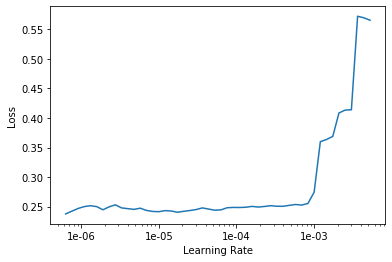

In [76]:
lr_find(learn)
learn.recorder.plot()

In [85]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


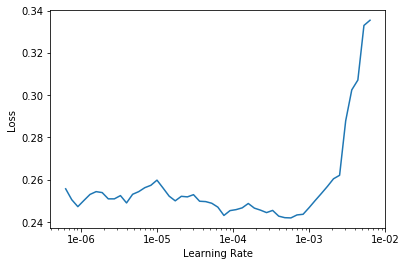

In [86]:
lr_find(learn)
learn.recorder.plot()

In [87]:
learn.fit_one_cycle(50, 5e-05, callbacks=[callbacks.SaveModelCallback(learn, monitor='custom_dice', every='improvement', name='model-stage7')])

epoch,train_loss,valid_loss,custom_dice,time
0,0.248511,0.224459,0.395124,00:45
1,0.243262,0.225442,0.369481,00:45
2,0.243552,0.224442,0.401454,00:45
3,0.241798,0.223900,0.391260,00:45
4,0.240822,0.223768,0.401881,00:45
5,0.241306,0.224176,0.384100,00:45
6,0.240988,0.221953,0.411952,00:45
7,0.241408,0.223108,0.419295,00:45
8,0.240466,0.220815,0.412971,00:45
9,0.239218,0.220758,0.397465,00:45


Better model found at epoch 0 with custom_dice value: 0.39512401819229126.
Better model found at epoch 2 with custom_dice value: 0.4014539420604706.
Better model found at epoch 4 with custom_dice value: 0.40188050270080566.
Better model found at epoch 6 with custom_dice value: 0.4119524359703064.
Better model found at epoch 7 with custom_dice value: 0.4192953109741211.
Better model found at epoch 10 with custom_dice value: 0.44514739513397217.
Better model found at epoch 32 with custom_dice value: 0.45339229702949524.
Better model found at epoch 34 with custom_dice value: 0.45515355467796326.


In [95]:
learn.load('model-stage7');

In [96]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


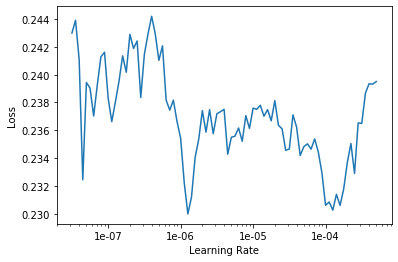

In [97]:
lr_find(learn, start_lr=1e-08, end_lr=1e-03)
learn.recorder.plot()

In [98]:
learn.fit_one_cycle(50, max_lr=slice(1e-06,1e-04), callbacks=[callbacks.SaveModelCallback(learn, monitor='custom_dice', every='improvement', name='model-stage8')])

epoch,train_loss,valid_loss,custom_dice,time
0,0.232895,0.217671,0.400156,00:45
1,0.232106,0.217188,0.433242,00:44
2,0.230852,0.217545,0.407661,00:45
3,0.231206,0.216132,0.421021,00:45
4,0.232425,0.216144,0.418050,00:45
5,0.232824,0.216965,0.427318,00:45
6,0.233351,0.218454,0.406204,00:45
7,0.232714,0.218980,0.399029,00:45
8,0.234655,0.219698,0.448733,00:45
9,0.234751,0.218564,0.447920,00:45


Better model found at epoch 0 with custom_dice value: 0.40015602111816406.
Better model found at epoch 1 with custom_dice value: 0.43324220180511475.
Better model found at epoch 8 with custom_dice value: 0.4487326741218567.
Better model found at epoch 10 with custom_dice value: 0.46184390783309937.
Better model found at epoch 24 with custom_dice value: 0.46761196851730347.
Better model found at epoch 38 with custom_dice value: 0.4689030349254608.
